
# Linear Regression — Life Expectancy (statsmodels)

Follows the lecture 06 checklist: apply the dataset's built-in transforms, build several OLS specifications (main effects, interactions, PCA-reduced features), compare via corrected AIC (AICc), and run residual + multicollinearity diagnostics. All data prep uses the AMA toolbox utilities.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from ama_tlbx.data import LifeExpectancyDataset, LECol
from ama_tlbx.analysis import FeatureGroup

sns.set_theme(style="whitegrid")


In [2]:
df_agg = LifeExpectancyDataset.from_csv(
    aggregate_by_country=2014, resolve_nand_pred="drop"
).tf_and_norm()
df = LifeExpectancyDataset.from_csv(resolve_nand_pred="median").tf_and_norm()
df_no_tf = LifeExpectancyDataset.from_csv(resolve_nand_pred="median").df_standardized
df_agg.head()


,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2014,0,-1.238854,0.868181,1.471512,-0.748754,-0.410361,1.213565,1.026147,-1.059125,...,1.379213,0.821577,1.331756,-0.571266,-0.609920,-0.532322,2.054563,1.956932,-1.284945,-0.976814
Albania,2014,0,0.814267,-2.530686,-1.111408,0.355633,0.473724,-1.208615,-0.941088,0.809728,...,-1.115737,-0.089841,-1.088540,-0.571266,0.471021,-0.579813,-0.991140,-0.957499,0.605782,0.556110
Algeria,2014,0,0.569292,-2.243824,0.801188,-0.748754,-0.561474,-0.554050,-0.941088,0.867827,...,-0.466231,0.437196,-0.434484,-0.571266,-0.669998,1.275866,0.664444,0.557845,0.473099,0.629106
Angola,2014,0,-2.195421,1.116741,1.499430,1.293135,-0.962188,1.163852,2.030888,-0.860620,...,1.131186,-1.108252,1.282081,1.312759,-0.741760,0.264106,1.101253,0.995516,-0.946604,-0.465839
Argentina,2014,0,0.662616,0.043858,0.248134,1.194968,0.816905,-0.408479,-0.721174,1.051807,...,-0.086294,-0.521774,-0.289026,-0.571266,1.000519,1.311523,-1.127469,-1.224576,1.030366,1.687554


In [3]:
assert df_agg.year.nunique() == 1


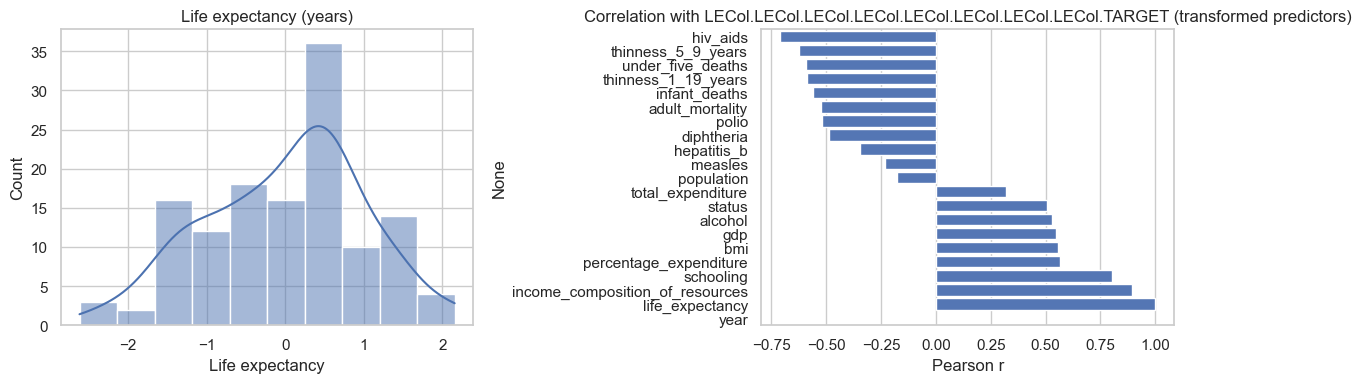

alcohol                            0.529510
gdp                                0.546855
bmi                                0.555226
percentage_expenditure             0.564462
schooling                          0.801796
income_composition_of_resources    0.892017
life_expectancy                    1.000000
year                                    NaN
Name: life_expectancy, dtype: float64

In [4]:
# Quick EDA: target distribution + strongest correlations (transformed predictors)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_agg["life_expectancy"], kde=True, ax=axes[0])
axes[0].set_title("Life expectancy (years)")
axes[0].set_xlabel("Life expectancy")

corr = (
    df_agg.drop(columns=["life_expectancy"], errors="ignore")
    .assign(**{"life_expectancy": df_agg["life_expectancy"]})
    .corr(numeric_only=True)["life_expectancy"]
    .sort_values()
)
sns.barplot(x=corr.values, y=corr.index, ax=axes[1], color="#4472c4")
axes[1].set_title(
    "Correlation with LECol.LECol.LECol.LECol.LECol.LECol.LECol.LECol.TARGET (transformed predictors)"
)
axes[1].set_xlabel("Pearson r")
plt.tight_layout()
plt.show()

corr.tail(8)


In [5]:
# PCA dimensionality reduction on specified feature groups (uses existing PCADimReduction)
feature_groups = [
    FeatureGroup(
        name="child_mortality",
        features=[LECol.INFANT_DEATHS, LECol.UNDER_FIVE_DEATHS],
    ),
    FeatureGroup(
        name="child_nutrition",
        features=[LECol.THINNESS_5_9_YEARS, LECol.THINNESS_1_19_YEARS],
    ),
    FeatureGroup(
        name="development",
        features=[LECol.GDP, LECol.PERCENTAGE_EXPENDITURE],
    ),
]

reduced_columns = [feature for g in feature_groups for feature in g.features]
print("Reducing columns:", reduced_columns)

pc_df = (
    LifeExpectancyDataset(df=df_agg)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=0.9
    )
    .fit()
    .result()
    .reduced_df
)
# Add all of the non-reduced columns back
pc_df = pc_df.assign(**df_agg.drop(columns=reduced_columns))

pc_df.head()


Reducing columns: [<LifeExpectancyColumn.INFANT_DEATHS: 'infant_deaths'>, <LifeExpectancyColumn.UNDER_FIVE_DEATHS: 'under_five_deaths'>, <LifeExpectancyColumn.THINNESS_5_9_YEARS: 'thinness_5_9_years'>, <LifeExpectancyColumn.THINNESS_1_19_YEARS: 'thinness_1_19_years'>, <LifeExpectancyColumn.GDP: 'gdp'>, <LifeExpectancyColumn.PERCENTAGE_EXPENDITURE: 'percentage_expenditure'>]


,child_mortality_PC1,child_nutrition_PC1,development_PC1,year,status,life_expectancy,adult_mortality,alcohol,hepatitis_b,measles,bmi,polio,total_expenditure,diphtheria,hiv_aids,population,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,
Afghanistan,2.073520,2.836555,-0.721447,2014,0,-1.238854,0.868181,-0.748754,1.213565,1.026147,-1.059125,1.379213,0.821577,1.331756,-0.571266,-0.532322,-1.284945,-0.976814
Albania,-1.307097,-1.377896,0.668036,2014,0,0.814267,-2.530686,0.355633,-1.208615,-0.941088,0.809728,-1.115737,-0.089841,-1.088540,-0.571266,-0.579813,0.605782,0.556110
Algeria,1.085805,0.864289,-0.870782,2014,0,0.569292,-2.243824,-0.748754,-0.554050,-0.941088,0.867827,-0.466231,0.437196,-0.434484,-0.571266,1.275866,0.473099,0.629106
Angola,2.158789,1.482639,-1.204874,2014,0,-2.195421,1.116741,1.293135,1.163852,2.030888,-0.860620,1.131186,-1.108252,1.282081,1.312759,0.264106,-0.946604,-0.465839
Argentina,0.317264,-1.663147,1.285113,2014,0,0.662616,0.043858,1.194968,-0.408479,-0.721174,1.051807,-0.086294,-0.521774,-0.289026,-0.571266,1.311523,1.030366,1.687554


Correlation matrix for df_agg:


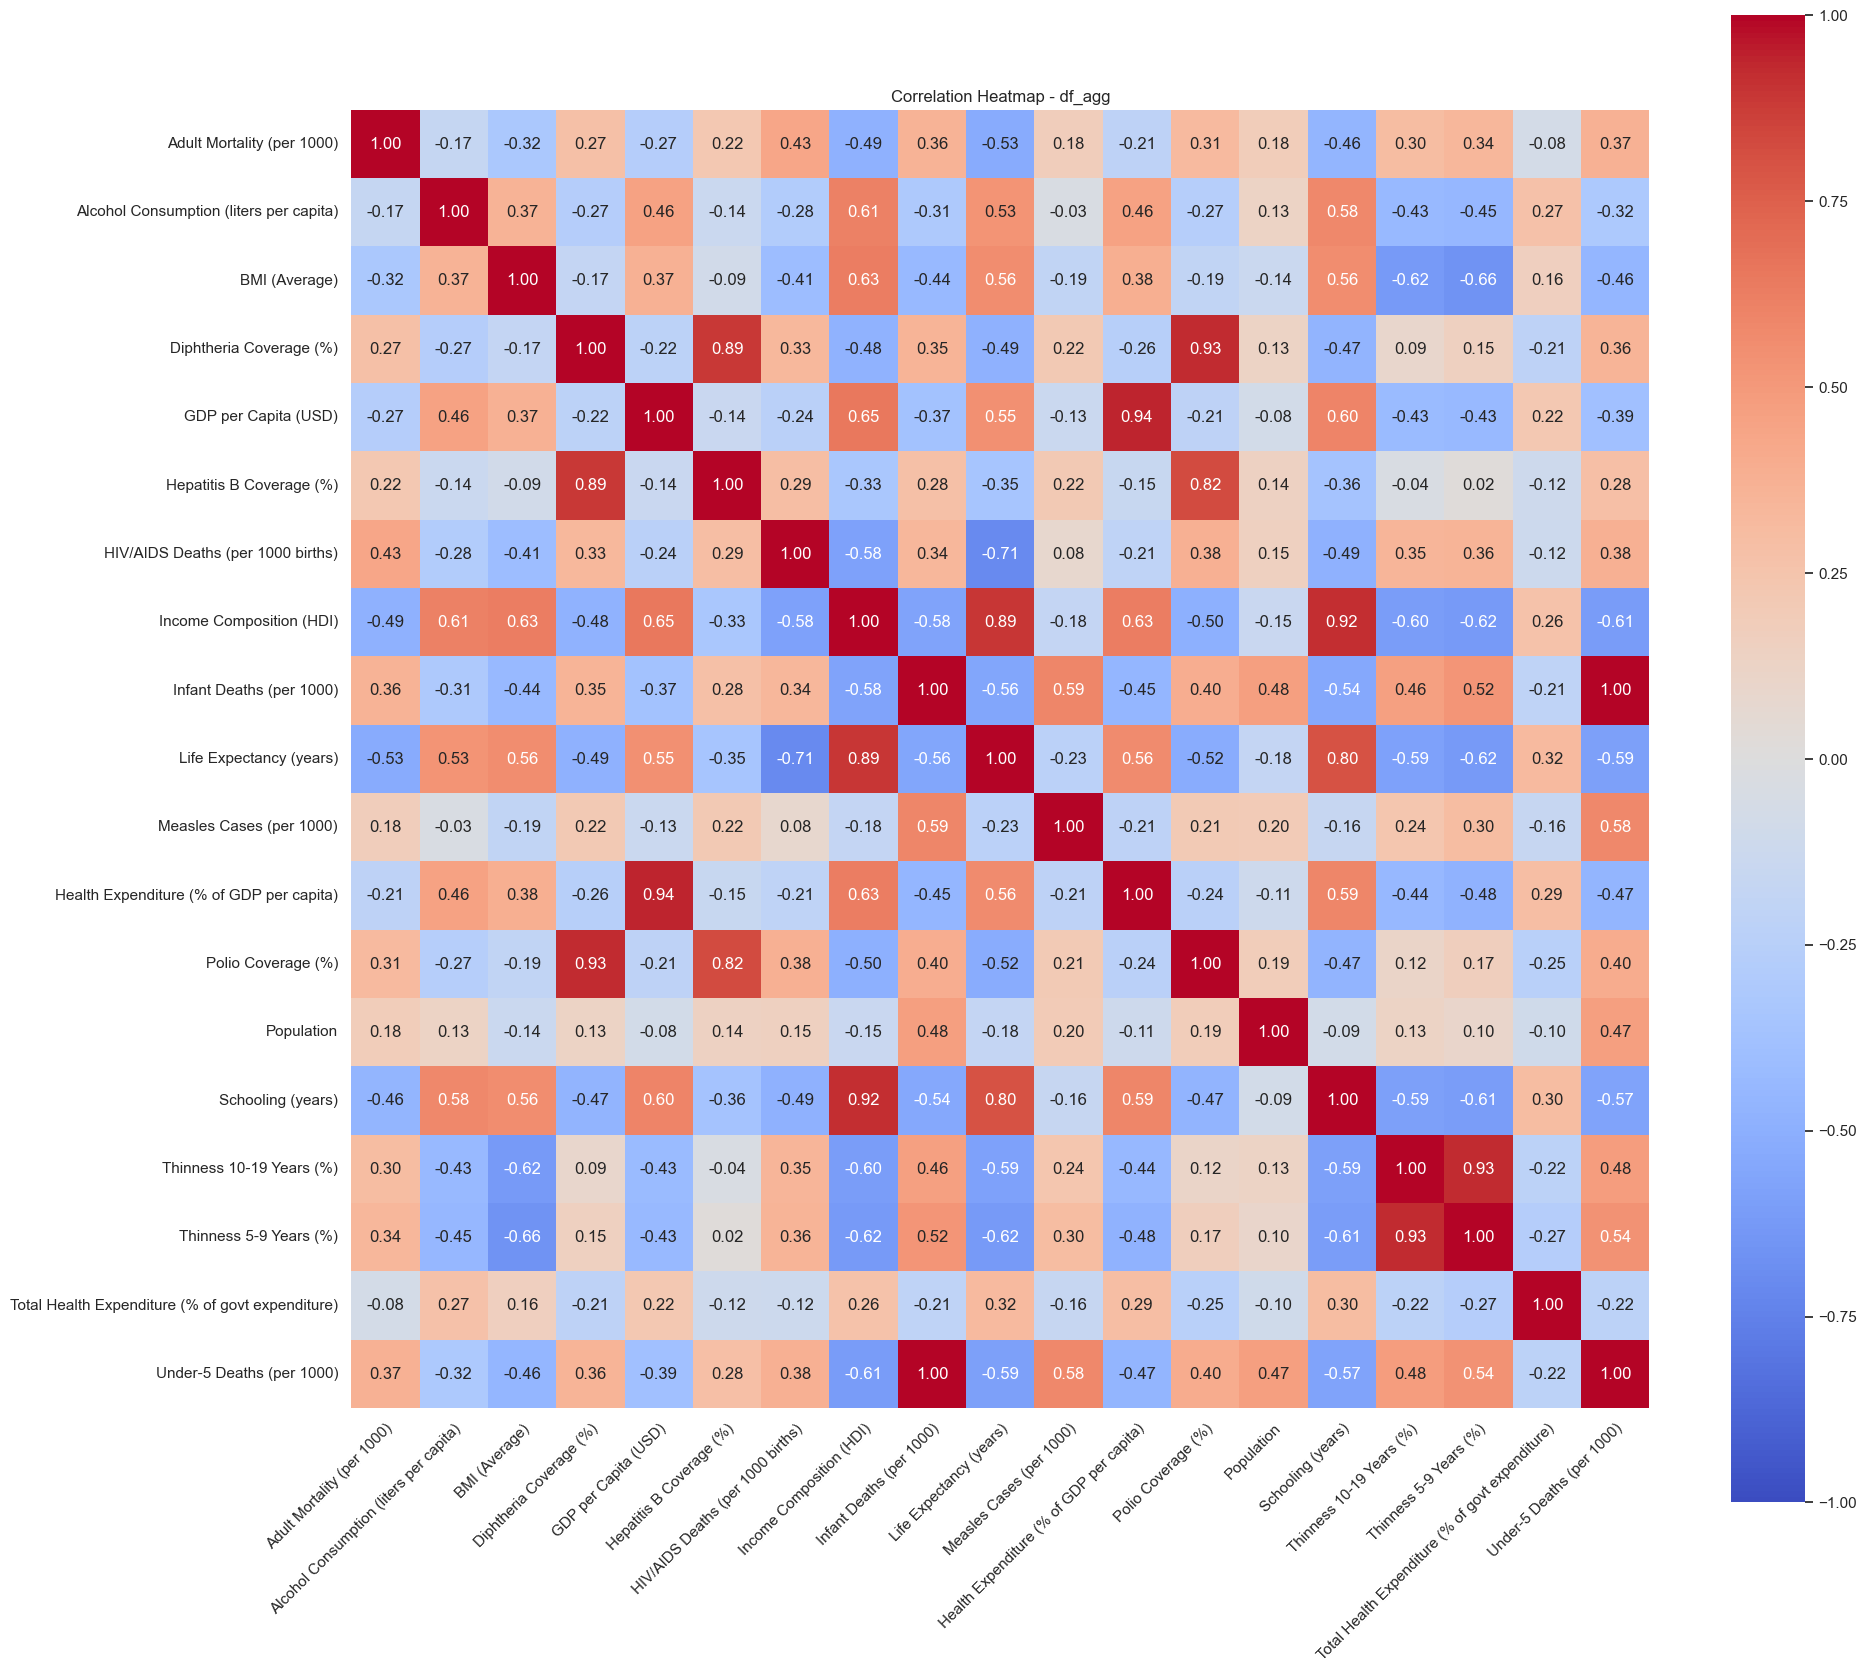


------------------------------------------------------------------------------------------------------------------------

Correlation matrix for df_dimred:


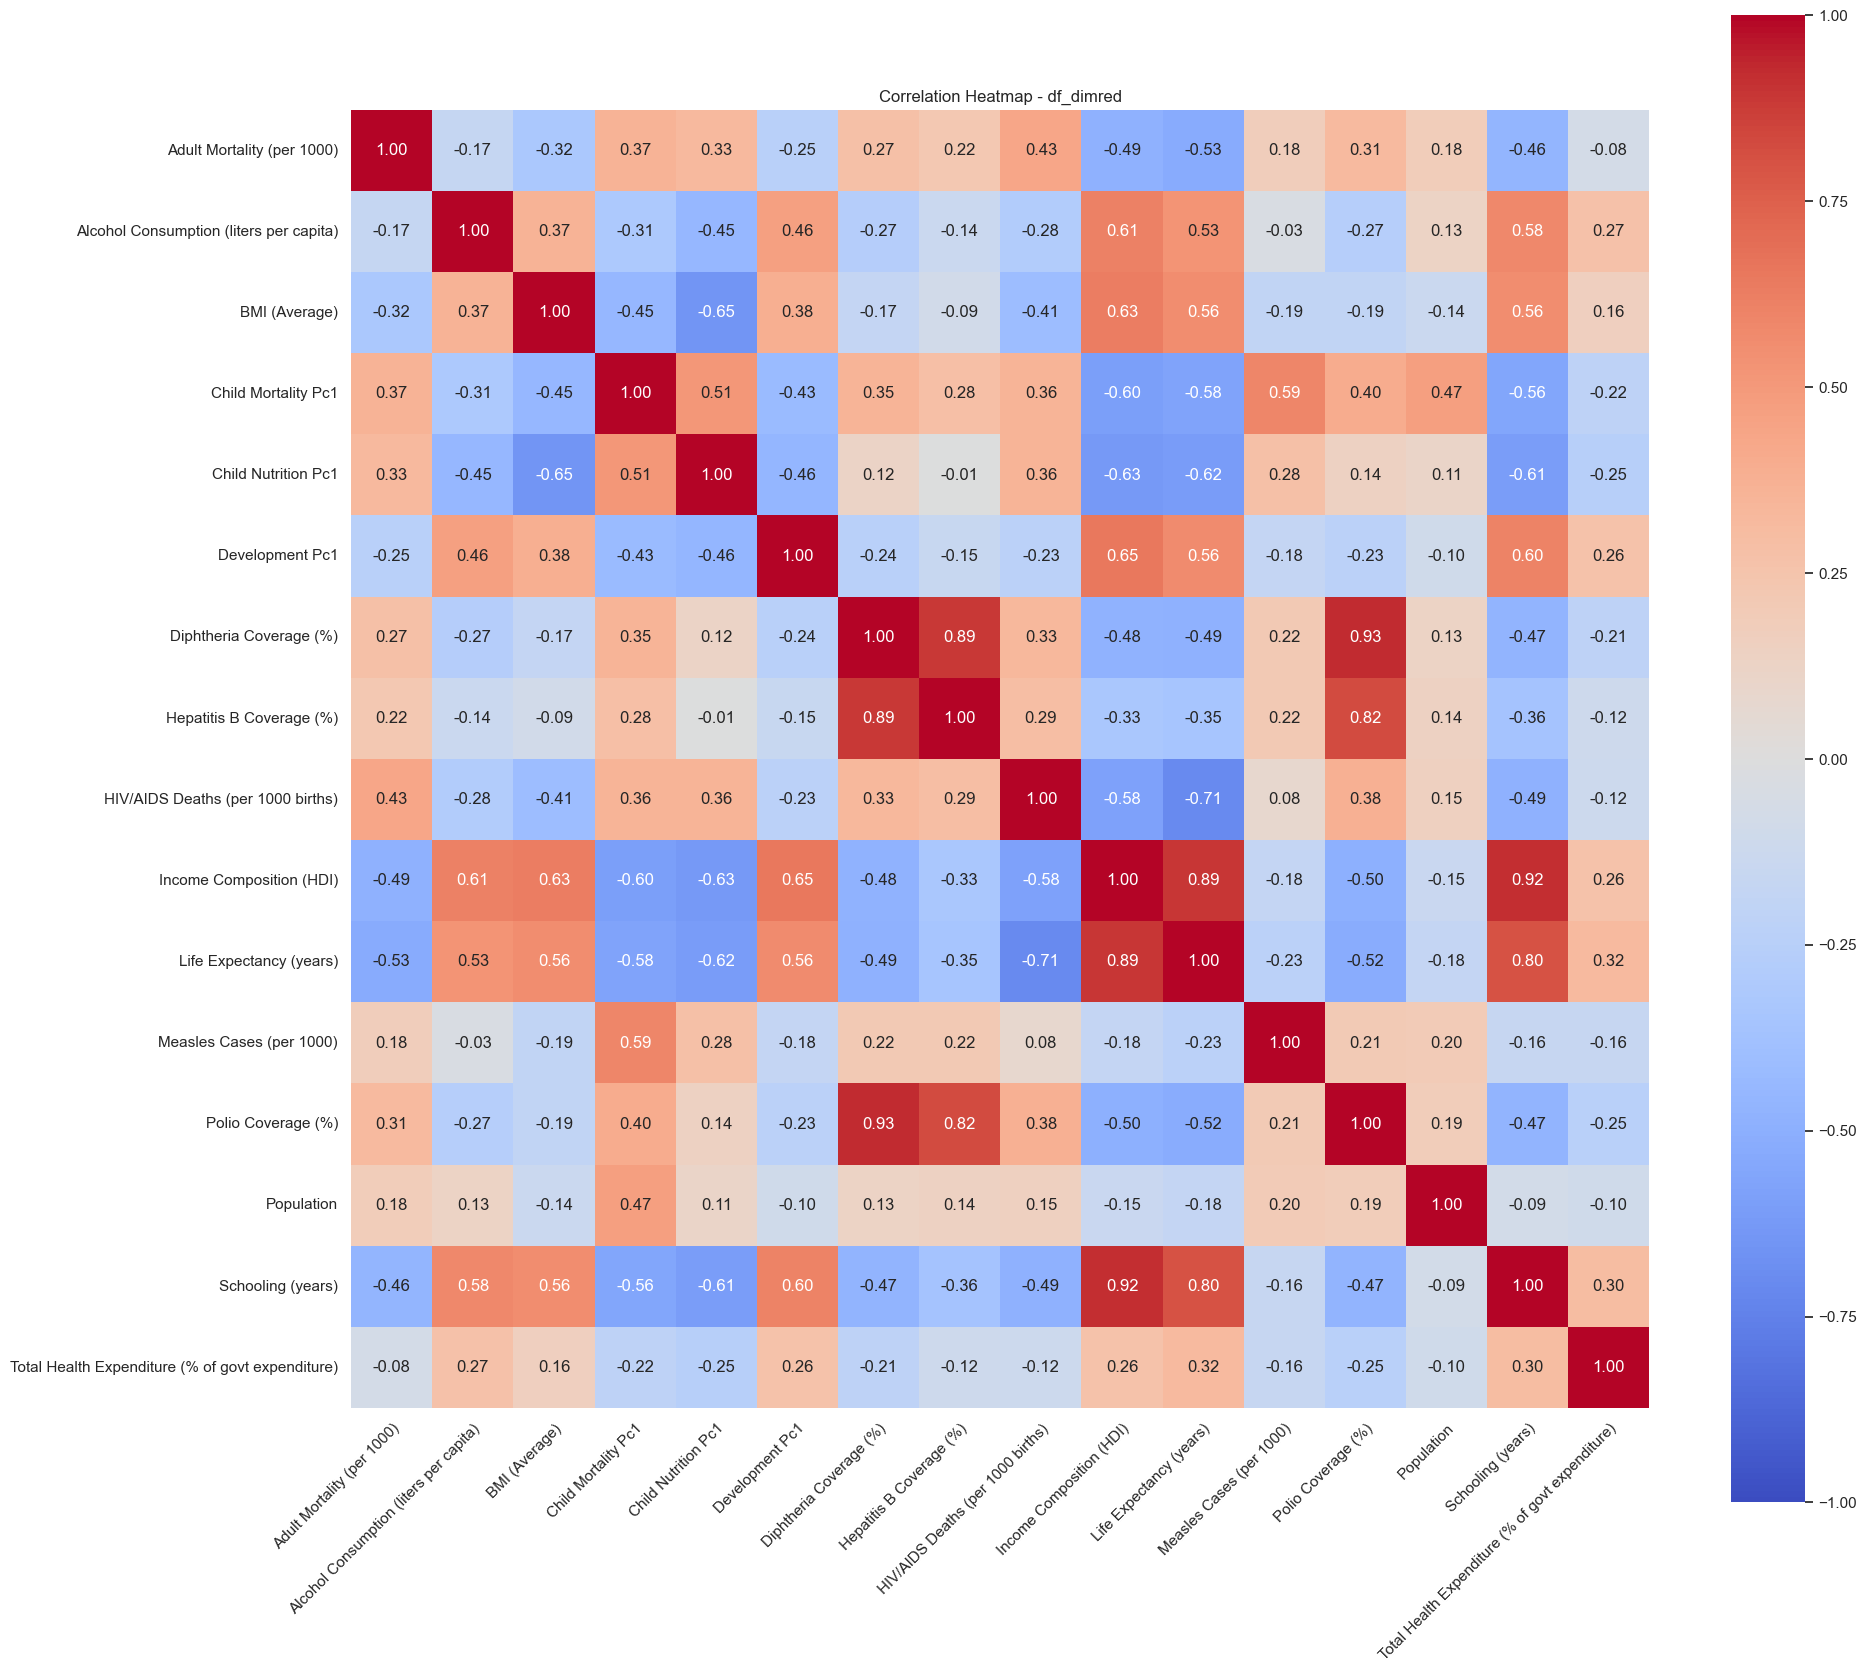


------------------------------------------------------------------------------------------------------------------------

Correlation matrix for df_full:


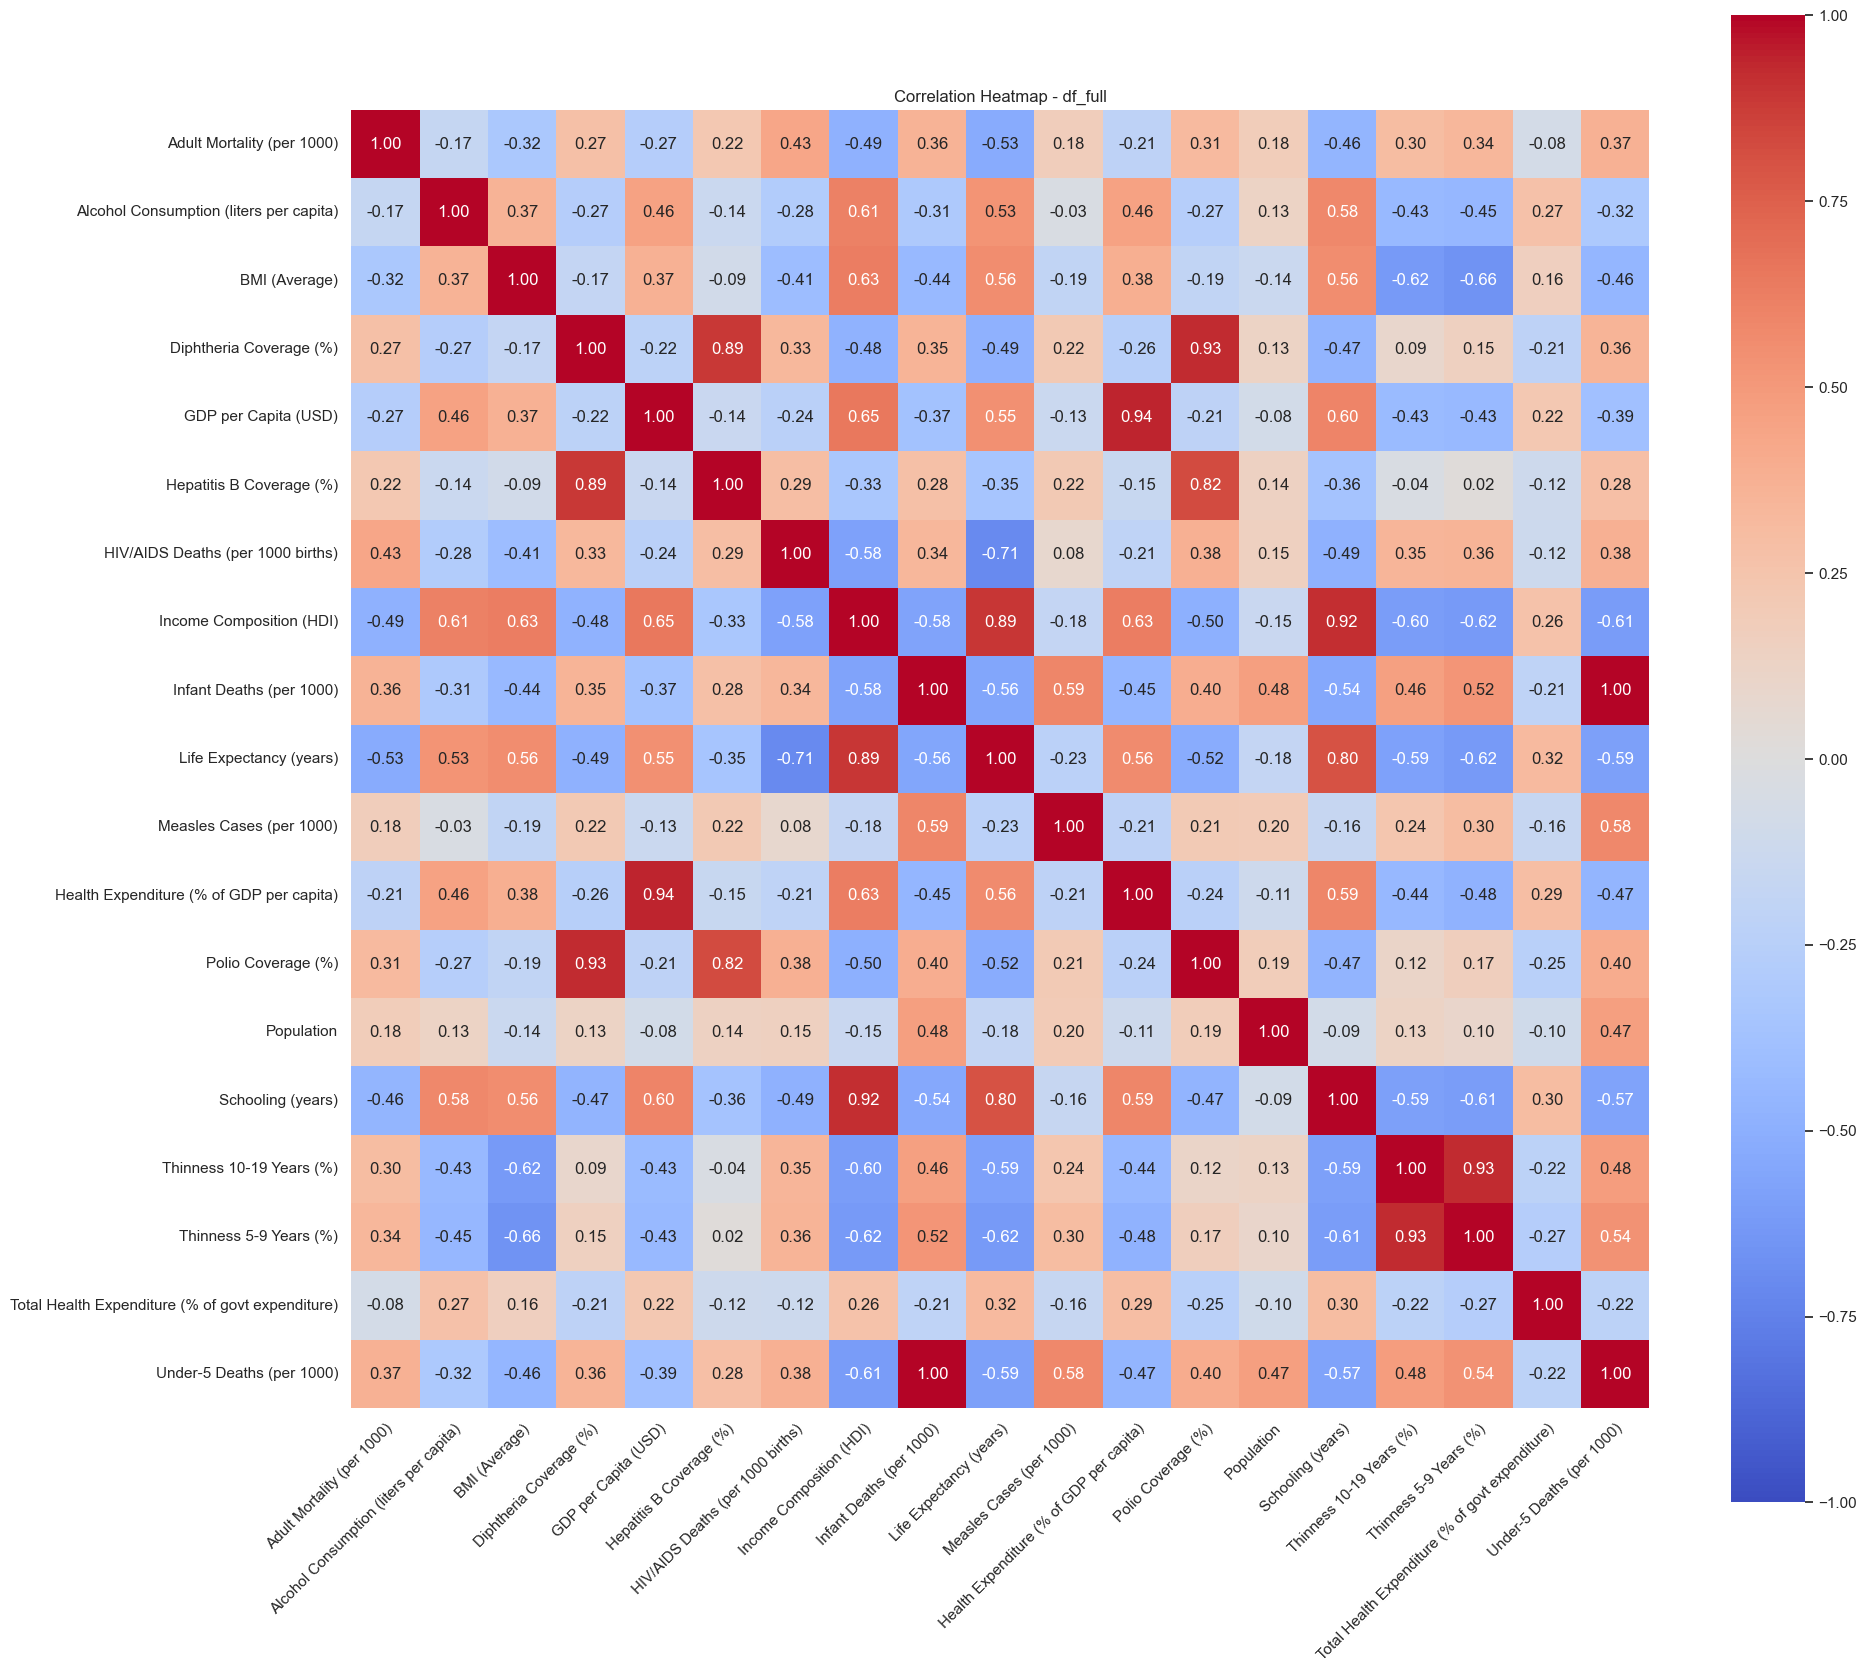


------------------------------------------------------------------------------------------------------------------------

Correlation matrix for df_no_tf:


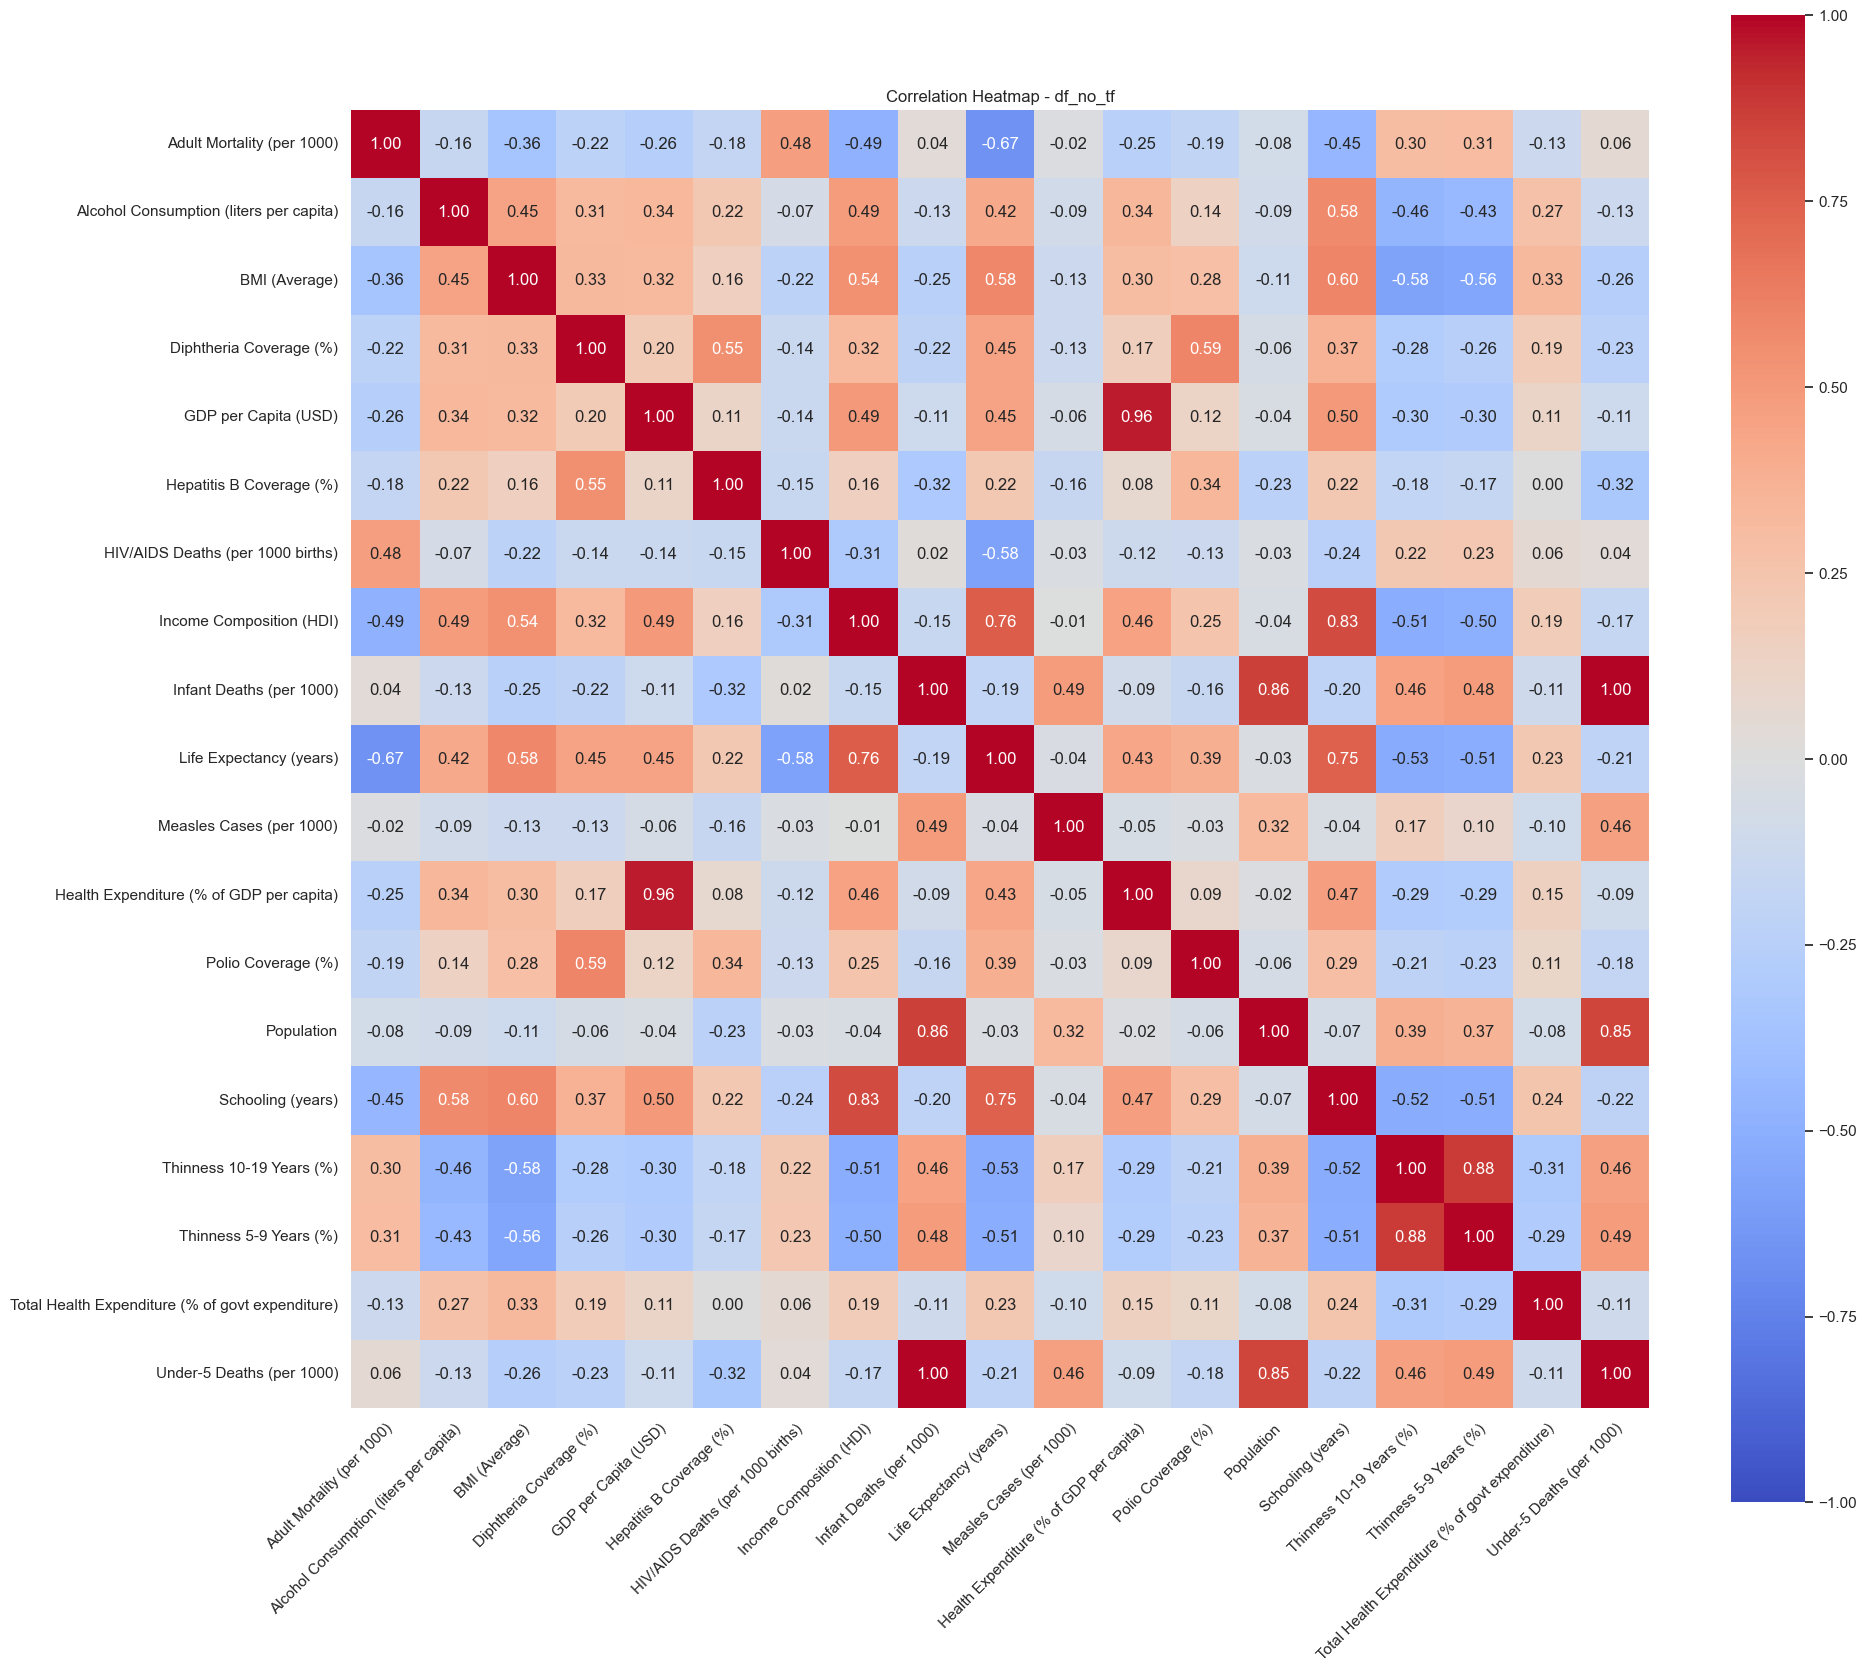


------------------------------------------------------------------------------------------------------------------------



In [6]:
from ama_tlbx.plotting import plot_correlation_heatmap

dfs_dict = {
    "df_agg": df_agg,
    "df_dimred": pc_df,
    "df_full": df_agg,
    "df_no_tf": df_no_tf,
}

corr_dict = {
    name: LifeExpectancyDataset(df=df_).make_correlation_analyzer().fit().result()
    for name, df_ in dfs_dict.items()
}
for name, corr_ in corr_dict.items():
    print(f"Correlation matrix for {name}:")
    plot_correlation_heatmap(corr_)
    plt.title(f"Correlation Heatmap - {name}")
    plt.show()
    print("\n" + "-" * 120 + "\n")


In [7]:
import statsmodels.api as sm


ols_dict = dict.fromkeys(dfs_dict.keys())
for name, df_ in dfs_dict.items():
    X = df_.drop(columns=[LECol.TARGET])
    y = df_[LECol.TARGET]

    X = sm.add_constant(X)  # add intercept
    ols_dict[name] = sm.OLS(y, X).fit()
    print(f"OLS Summary for {name}:")
    print(ols_dict[name].summary())
    print("-" * 120 + "\n")


OLS Summary for df_agg:
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     46.76
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           4.47e-44
Time:                        15:34:17   Log-Likelihood:                -41.928
No. Observations:                 131   AIC:                             123.9
Df Residuals:                     111   BIC:                             181.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

- Adj. R-squared: 0.870 vs Adj. R-squared: 0.862 if we combine child_mortality, child_thinness as well as GPP + expenditure (agg=2014)
- AIC 214.8 vs 123.9 if we don't use any transformations vs using all transformations as per `life_expectancy_columns.py`
- If we don't aggregate by country (i.e., use all years), we get Adj. R-squared: 0.903 and AIC: -137.4

In [8]:
# Helpers: fit models, compute AICc, compare


def fit_ols(name: str, formula: str, data: pd.DataFrame):
    res = ols(formula=formula, data=data).fit()
    res.model_name = name
    return res


def aicc(res) -> float:
    k = res.params.size  # includes intercept
    n = res.nobs
    return res.aic + (2 * k * (k + 1)) / (n - k - 1)


def compare_models(models: dict[str, object]) -> pd.DataFrame:
    rows = []
    for name, res in models.items():
        rows.append(
            {
                "model": name,
                "aic": res.aic,
                "aicc": aicc(res),
                "bic": res.bic,
                "adj_r2": res.rsquared_adj,
                "rmse": np.sqrt(res.mse_resid),
            }
        )
    return pd.DataFrame(rows).sort_values("aicc").reset_index(drop=True)


Diagnostics for model: df_agg


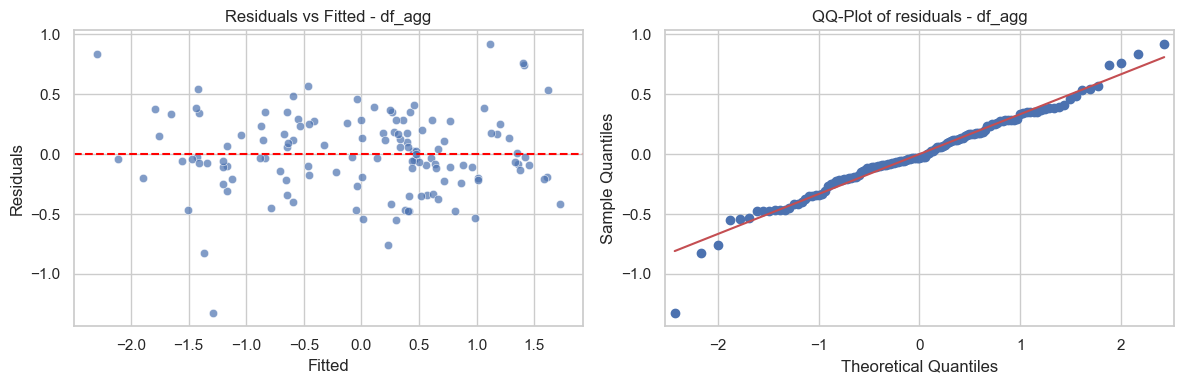


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_dimred


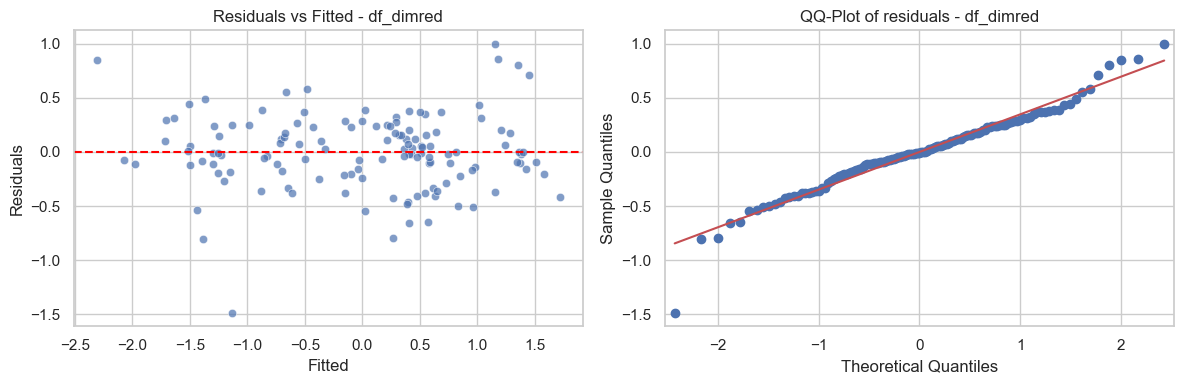


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_full


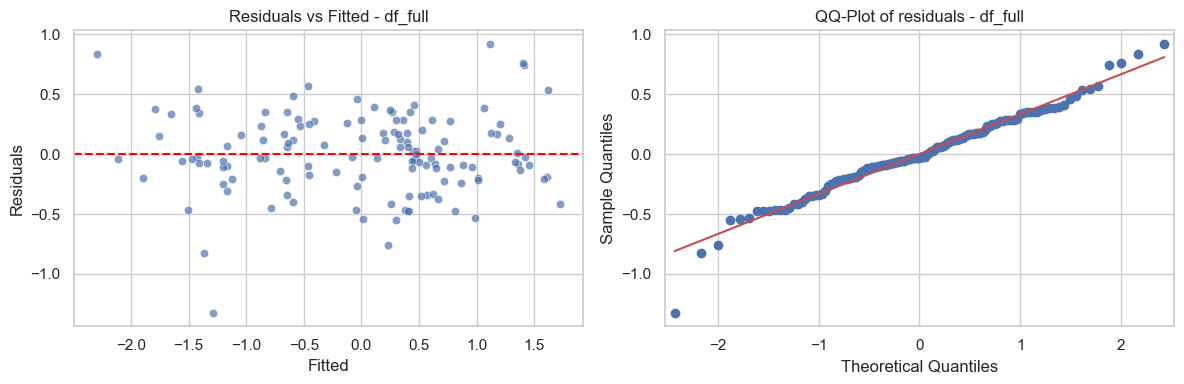


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_no_tf


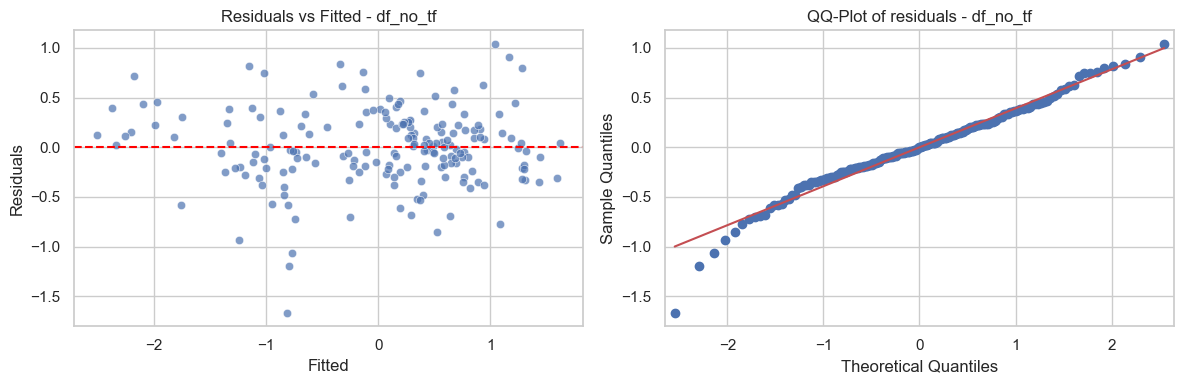


------------------------------------------------------------------------------------------------------------------------



In [22]:
# Diagnostics: residuals + QQ

for name, model in ols_dict.items():
    print(f"Diagnostics for model: {name}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[0], alpha=0.7)
    axes[0].axhline(0, color="red", linestyle="--")
    axes[0].set_xlabel("Fitted")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"Residuals vs Fitted - {name}")

    sm.qqplot(model.resid, line="s", ax=axes[1])
    axes[1].set_title(f"QQ-Plot of residuals - {name}")
    plt.tight_layout()
    plt.show()
    print("\n" + "-" * 120 + "\n")


ACF Plot for model residuals: df_agg


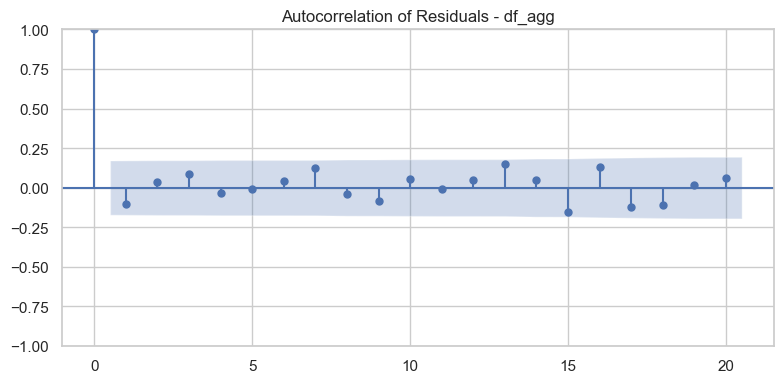


------------------------------------------------------------------------------------------------------------------------

ACF Plot for model residuals: df_dimred


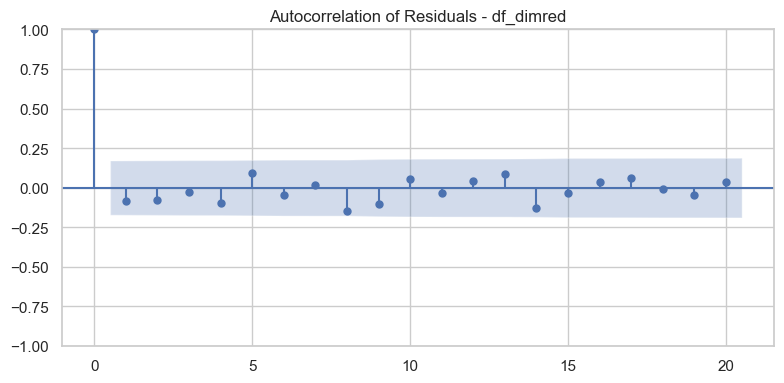


------------------------------------------------------------------------------------------------------------------------

ACF Plot for model residuals: df_full


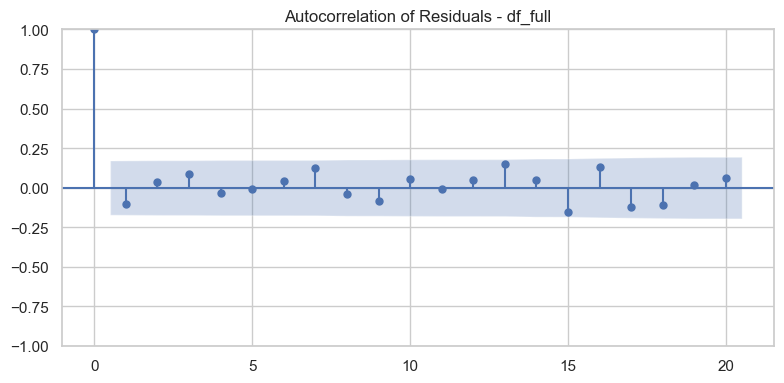


------------------------------------------------------------------------------------------------------------------------

ACF Plot for model residuals: df_no_tf


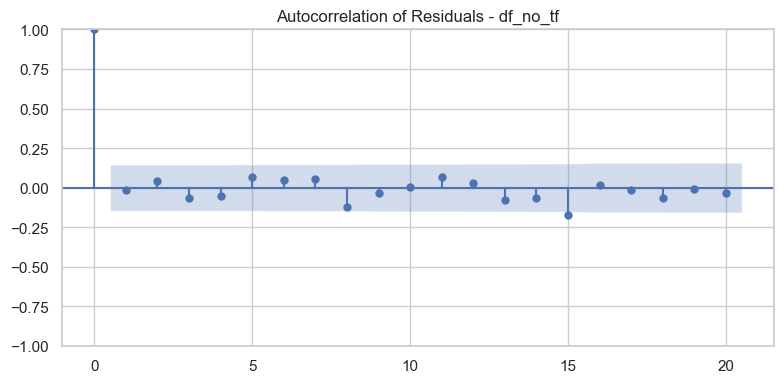


------------------------------------------------------------------------------------------------------------------------



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

for name, model in ols_dict.items():
    print(f"ACF Plot for model residuals: {name}")
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(model.resid, ax=ax, lags=20)
    plt.title(f"Autocorrelation of Residuals - {name}")
    plt.tight_layout()
    plt.show()
    print("\n" + "-" * 120 + "\n")


,model,aic,aicc,bic,adj_r2
0,df_agg,123.856268,131.492631,181.360214,0.869939
2,df_full,123.856268,131.492631,181.360214,0.869939
1,df_dimred,129.095164,134.511093,177.973518,0.862017
3,df_no_tf,214.845679,219.508256,275.825916,0.829218


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_45282/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


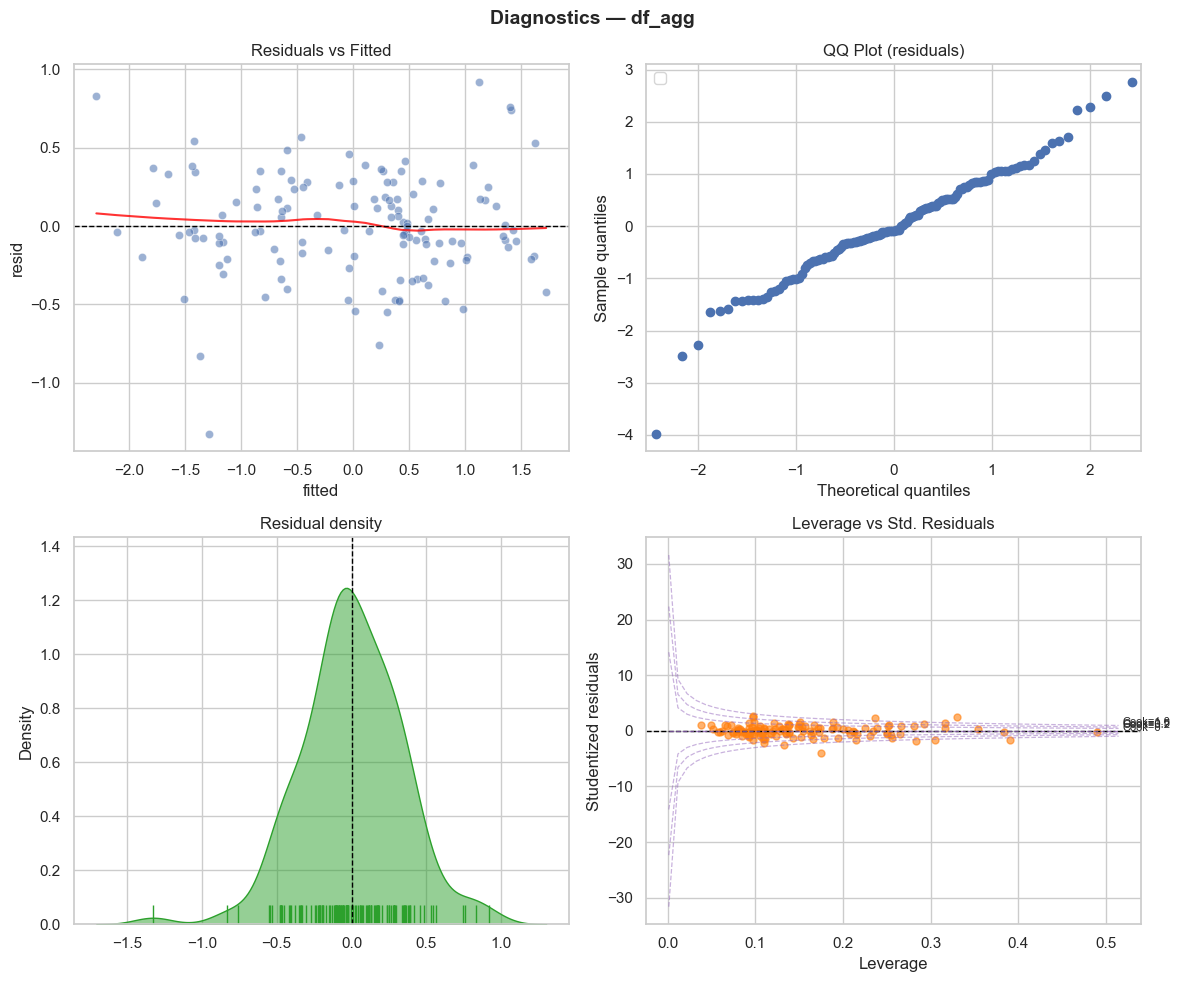

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_45282/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


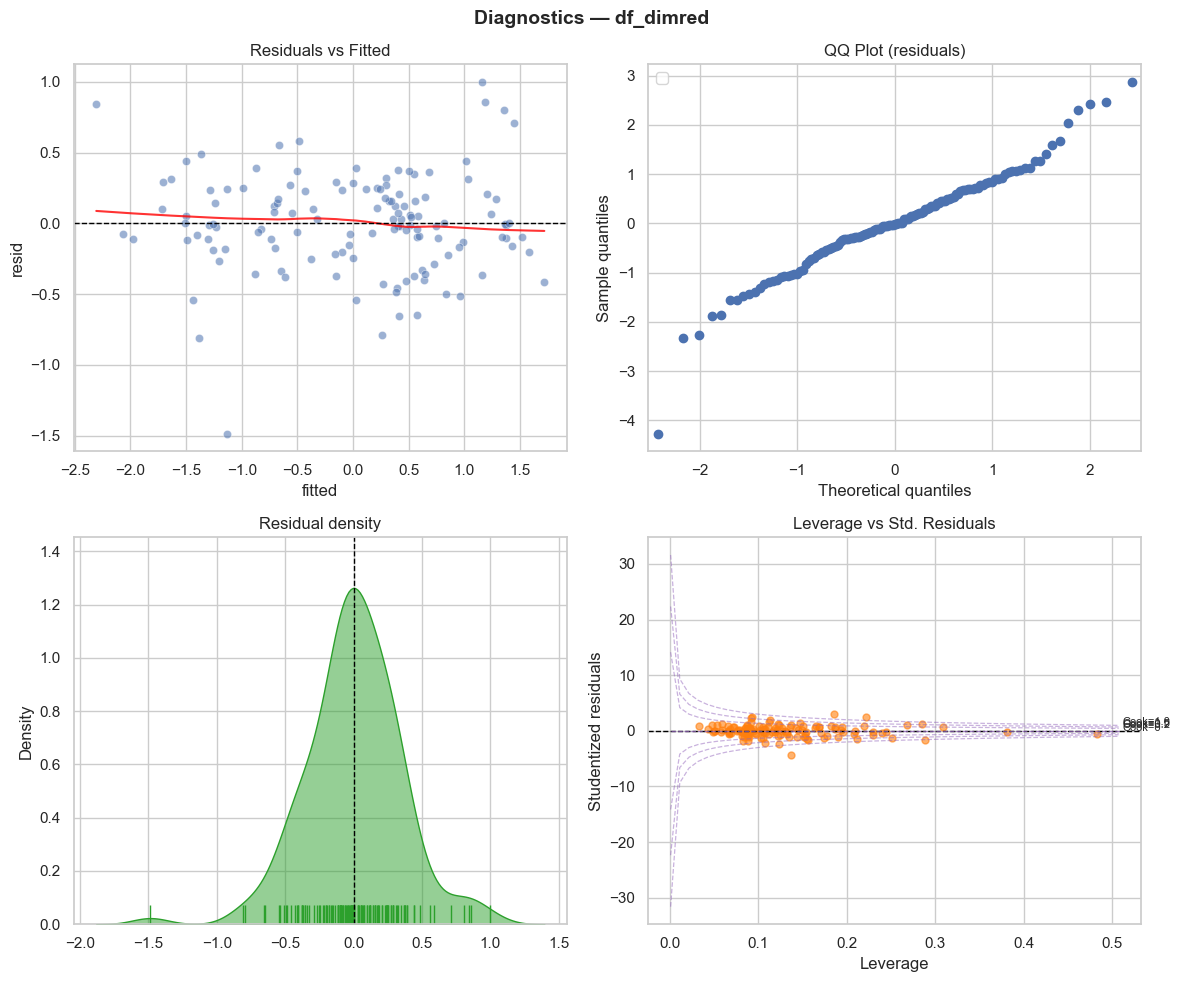

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_45282/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


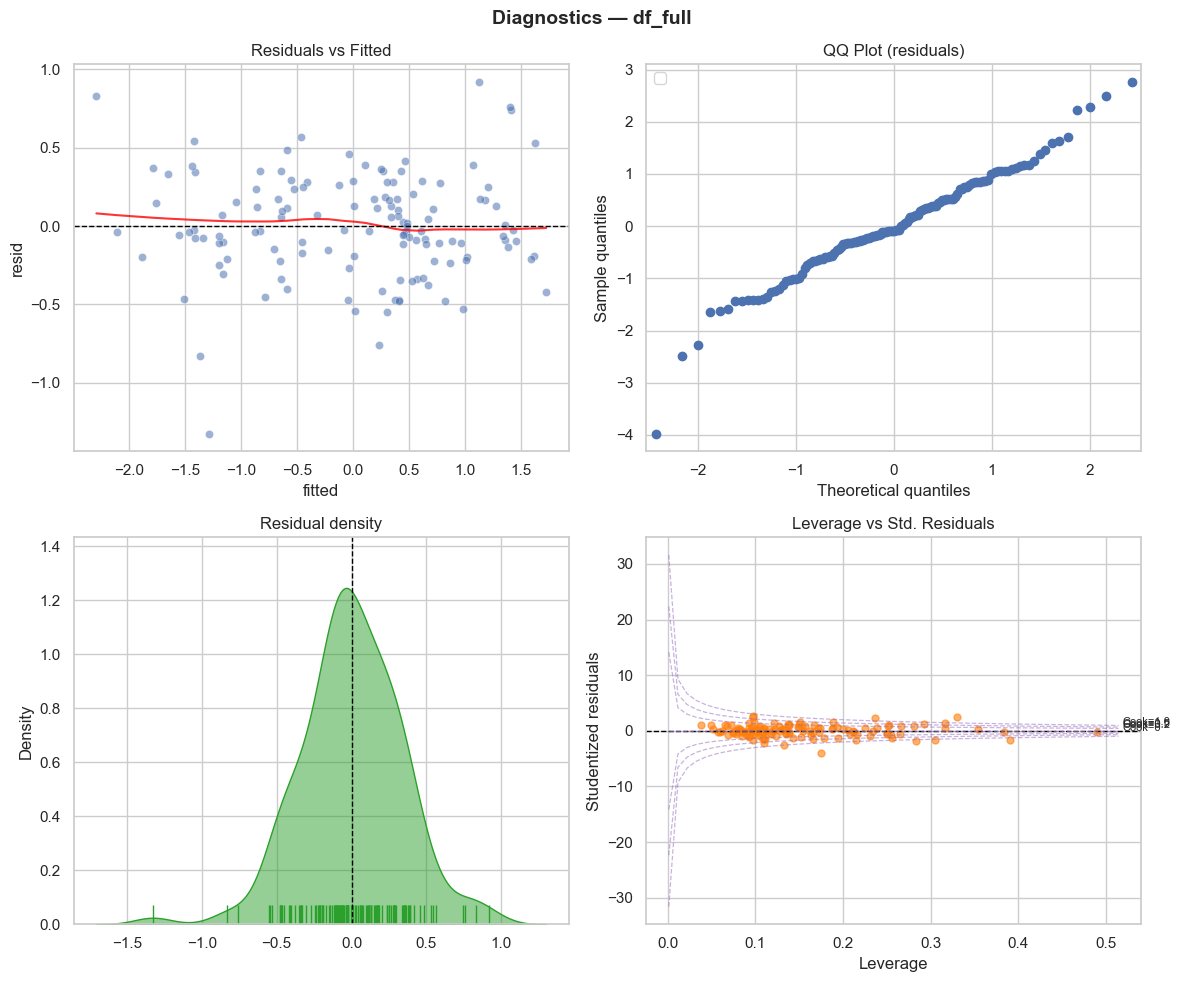

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_45282/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


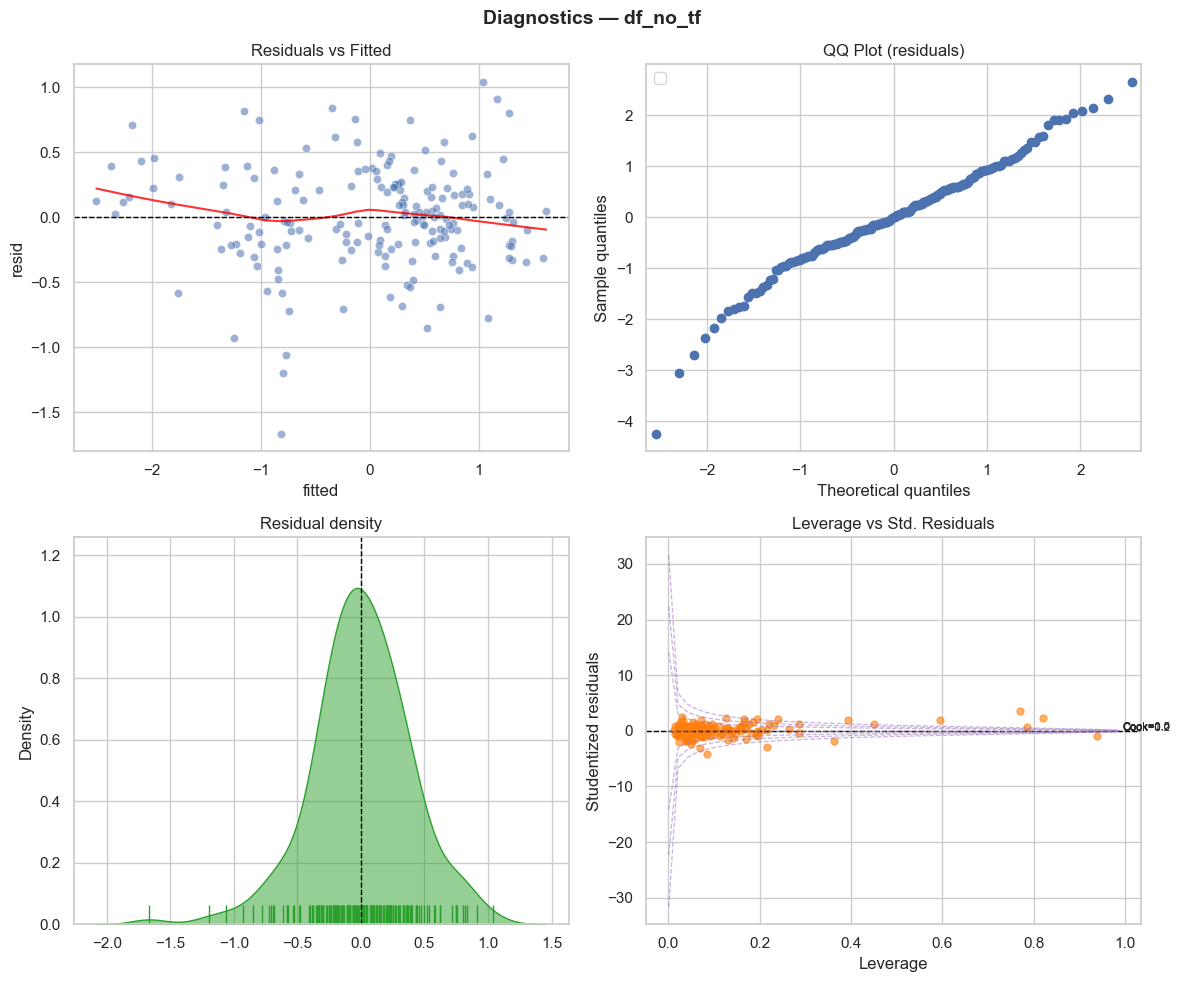

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

sns.set_theme(style="whitegrid")


def aicc(res):
    k = res.params.size
    n = res.nobs
    return res.aic + (2 * k * (k + 1)) / max(n - k - 1, 1)


def cooksd_contours(ax, leverage, resid_studentized, line_coords=(0, 0.2, 0.5, 1.0)):
    # add Cook's distance contours to leverage plot
    for d in line_coords:
        x = np.linspace(0.001, leverage.max() * 1.05, 50)
        y = np.sqrt(d * (1 - x) / x)
        ax.plot(x, y, color="tab:purple", alpha=0.5, linestyle="--", linewidth=0.9)
        ax.plot(x, -y, color="tab:purple", alpha=0.5, linestyle="--", linewidth=0.9)
        ax.annotate(
            f"Cook={d}",
            xy=(x[-1], y[-1]),
            xytext=(3, 0),
            textcoords="offset points",
            fontsize=8,
        )


def plot_diagnostics(name, res):
    fitted = res.fittedvalues
    resid = res.resid
    stud_resid = res.get_influence().resid_studentized_internal
    leverage = res.get_influence().hat_matrix_diag
    df = pd.DataFrame(
        {
            "fitted": fitted,
            "resid": resid,
            "stud_resid": stud_resid,
            "leverage": leverage,
        }
    )

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Diagnostics — {name}", fontweight="bold", fontsize=14)

    # 1) Residuals vs Fitted with LOESS smoothing
    sns.scatterplot(data=df, x="fitted", y="resid", alpha=0.55, s=35, ax=axes[0, 0])
    sns.regplot(
        data=df,
        x="fitted",
        y="resid",
        scatter=False,
        lowess=True,
        line_kws={"color": "red", "lw": 1.5, "alpha": 0.8},
        ax=axes[0, 0],
    )
    axes[0, 0].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[0, 0].set_title("Residuals vs Fitted")

    # 2) QQ plot with 95% band
    qq = ProbPlot(resid, fit=True)
    theo = qq.theoretical_quantiles
    sample = qq.sample_quantiles
    qq.qqplot(ax=axes[0, 1])

    # axes[0, 1].scatter(theo, sample, alpha=0.6, s=20, color="tab:blue")
    # axes[0, 1].plot(
    #     theo, slope * theo + intercept, color="red", lw=1.5, label="Fit line"
    # )
    # axes[0, 1].plot(theo, theo, color="black", lw=1, linestyle="--", label="45°")

    # # 95% CI (approx) from sm ProbPlot
    # ci = qq.probplot(sorted=True, fit=True)[1]
    axes[0, 1].set_title("QQ Plot (residuals)")
    axes[0, 1].set_xlabel("Theoretical quantiles")
    axes[0, 1].set_ylabel("Sample quantiles")
    axes[0, 1].legend()

    # 3) Density + rug of residuals
    sns.kdeplot(resid, fill=True, alpha=0.5, color="tab:green", ax=axes[1, 0])
    sns.rugplot(resid, height=0.05, color="tab:green", ax=axes[1, 0])
    axes[1, 0].axvline(0, color="black", linestyle="--", lw=1)
    axes[1, 0].set_title("Residual density")

    # 4) Leverage vs Studentized Residuals (Cook's contours)
    axes[1, 1].scatter(leverage, stud_resid, alpha=0.6, s=25, color="tab:orange")
    axes[1, 1].axhline(0, color="black", linestyle="--", lw=1)
    axes[1, 1].set_xlabel("Leverage")
    axes[1, 1].set_ylabel("Studentized residuals")
    axes[1, 1].set_title("Leverage vs Std. Residuals")
    cooksd_contours(axes[1, 1], leverage, stud_resid)

    plt.tight_layout()
    plt.show()


# Compare AICc across your three fits
aicc_table = pd.DataFrame(
    {
        "model": list(ols_dict.keys()),
        "aic": [m.aic for m in ols_dict.values()],
        "aicc": [aicc(m) for m in ols_dict.values()],
        "bic": [m.bic for m in ols_dict.values()],
        "adj_r2": [m.rsquared_adj for m in ols_dict.values()],
    }
).sort_values("aicc")
display(aicc_table)

# Run diagnostics for each model
for name, res in ols_dict.items():
    plot_diagnostics(name, res)


In [ ]:
ds_raw = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
tf_map = {}
df = ds_raw.tf_and_norm()


df_supervised = (
    df
    # tf to multi-index
    .reset_index()
    .set_index([LECol.COUNTRY, LECol.YEAR])  # MultiIndex
    .sort_index()
    # 1-year lag of life expectancy per country
    .assign(
        **{
            f"{LECol.TARGET}_lag1": lambda d: d.groupby(level=LECol.COUNTRY)[
                LECol.TARGET
            ].shift(1)
        }
    )
    .dropna(subset=[f"{LECol.TARGET}_lag1"])
    .reset_index()
)

# Choose features: multivariate + lag + time
feature_cols = [
    *LECol.numeric_columns(),
    f"{LECol.TARGET}_lag1",
]

X_core = df_supervised[feature_cols]

# Add country fixed effects and a linear time trend
X_design = pd.concat(
    [
        X_core,
        pd.get_dummies(
            df_supervised[LECol.COUNTRY],
            prefix="country",
            drop_first=True,
            dtype=np.int16,
        ),
        df_supervised[[LECol.YEAR]].assign(
            year=df_supervised[LECol.YEAR].dt.year
            - df_supervised[LECol.YEAR].dt.year.min()
        ),  # numeric time trend
    ],
    axis=1,
)

y = df_supervised[LECol.TARGET]

X_design = sm.add_constant(X_design)

X_design


,const,life_expectancy,status,adult_mortality,infant_deaths,under_five_deaths,hiv_aids,measles,hepatitis_b,polio,...,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Zambia,country_Zimbabwe,year
0,1.0,-1.592226,0,0.963092,1.604029,1.596697,-0.528429,1.774583,1.051928,1.809145,...,0,0,0,0,0,0,0,0,0,0
1,1.0,-1.489886,0,-3.215871,1.604029,1.596697,-0.528429,1.386863,1.027605,1.794843,...,0,0,0,0,0,0,0,0,0,1
2,1.0,-1.433030,0,0.897585,1.597172,1.596697,-0.528429,1.037313,1.002616,1.719862,...,0,0,0,0,0,0,0,0,0,2
3,1.0,-1.398916,0,0.891106,1.597172,1.587334,-0.528429,0.871990,0.950485,2.160142,...,0,0,0,0,0,0,0,0,0,3
4,1.0,-1.364803,0,0.884582,1.583221,1.577815,-0.528429,1.186448,0.976923,1.407786,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,1.0,-1.921991,0,1.450692,0.944137,1.022418,2.871532,1.805761,1.858361,0.212208,...,0,0,0,0,0,0,0,0,1,9
1512,1.0,-1.637711,0,1.329261,0.923564,0.996453,2.677605,-1.020133,-0.490957,-0.167615,...,0,0,0,0,0,0,0,0,1,10
1513,1.0,-1.444401,0,1.254474,0.880200,0.955149,2.205281,-1.020133,-1.001352,-0.437103,...,0,0,0,0,0,0,0,0,1,11
1514,1.0,-1.285205,0,1.185356,0.857298,0.910623,1.919971,-1.020133,-0.631550,-0.437103,...,0,0,0,0,0,0,0,0,1,12


In [21]:
model = sm.OLS(y, X_design)
res = model.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.887e+28
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:38:44   Log-Likelihood:                 46731.
No. Observations:                1516   AIC:                        -9.316e+04
Df Residuals:                    1363   BIC:                        -9.234e+04
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
res.resid


country
Afghanistan                          -0.206258
Albania                               0.153226
Algeria                               0.010080
Angola                               -0.928884
Antigua and Barbuda                   0.048524
                                        ...   
Venezuela (Bolivarian Republic of)    0.231702
Viet Nam                              0.493780
Yemen                                -0.330114
Zambia                                0.104575
Zimbabwe                             -0.579559
Length: 183, dtype: float64

In [ ]:
ds_raw = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
tf_map = {}
df = ds_raw.tf_and_norm()


df_supervised = (
    df
    # tf to multi-index
    .reset_index()
    .set_index([LECol.COUNTRY, LECol.YEAR])  # MultiIndex
    .sort_index()
    # 1-year lag of life expectancy per country
    .assign(
        **{
            f"{LECol.TARGET}_lag1": lambda d: d.groupby(level=LECol.COUNTRY)[
                LECol.TARGET
            ].shift(1)
        }
    )
    .dropna(subset=[f"{LECol.TARGET}_lag1"])
    .reset_index()
)

# Choose features: multivariate + lag + time
feature_cols = [
    *LECol.numeric_columns(),
    f"{LECol.TARGET}_lag1",
]

X_core = df_supervised[feature_cols]

# Add country fixed effects and a linear time trend
X_design = pd.concat(
    [
        X_core,
        pd.get_dummies(
            df_supervised[LECol.COUNTRY],
            prefix="country",
            drop_first=True,
            dtype=np.int16,
        ),
        df_supervised[[LECol.YEAR]].assign(
            year=df_supervised[LECol.YEAR].dt.year
            - df_supervised[LECol.YEAR].dt.year.min()
        ),  # numeric time trend
    ],
    axis=1,
)

y = df_supervised[LECol.TARGET]

X_design = sm.add_constant(X_design)

X_design


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error,

X = X_design
X.columns = X.columns.map(lambda x: x.value if isinstance(x, LECol) else x)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
print("R2 (test):", r2_score(y_test, y_pred_test))
print("RMSE (test9):", root_mean_squared_error(y_test, y_pred_test))


R²: 0.9999592025300442
RMSE: 0.005786650109052346


In [ ]:
rf


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
